In [14]:
from duckduckgo_search import ddg_images

from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

from time import sleep

# Setup

Setting up PyTorch so that it is using the Apple Silicon GPU on my mac. Following instructions from this [link](https://www.mrdbourke.com/pytorch-apple-silicon/).

In [28]:
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


# Goal
Identify if an image is a deadlift or squat using a neural network.

# Data

Grab images from duck duck go of people squatting and deadlifting using a barbell

In [5]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Check search terms and images

Searching for 'barbell deadlift photos'


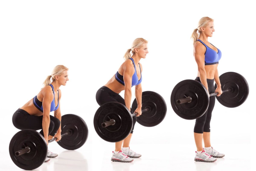

In [12]:
urls = search_images('barbell deadlift photos', max_images=1)
dest = 'deadlift.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'barbell back squat photos'


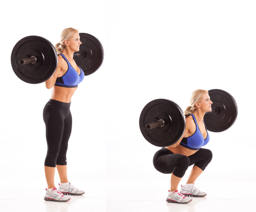

In [13]:
download_url(search_images('barbell back squat photos', max_images=1)[0], 'squat.jpg', show_progress=False)
Image.open('squat.jpg').to_thumb(256, 256)

### Download images

In [16]:
searches = 'barbell back squat', 'barbell deadlift'
path = Path('squat_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} female photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} male photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'barbell back squat photo'
Searching for 'barbell back squat female photo'
Searching for 'barbell back squat male photo'
Searching for 'barbell deadlift photo'
Searching for 'barbell deadlift female photo'
Searching for 'barbell deadlift male photo'


/Users/jonathan_novak/Library/Caches/pypoetry/virtualenvs/hello-world-pytorch-fastai-yUreHNf2-py3.7/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### Data cleanup

In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

# Train Model

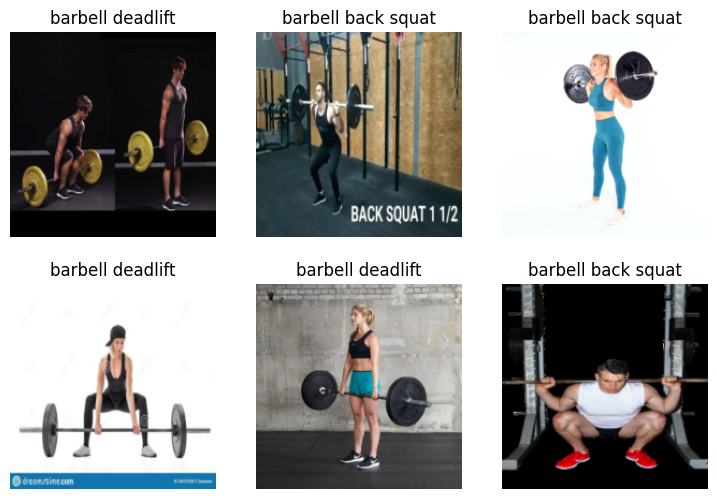

In [19]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [30]:
#Model 1
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.073872,0.661472,0.333333,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.530359,0.542139,0.212121,00:00
1,0.478972,0.562703,0.212121,00:00
2,0.348064,0.466235,0.121212,00:00


In [34]:
#Model 2
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.200521,0.884468,0.363636,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.544526,0.644336,0.242424,00:00
1,0.408311,0.557744,0.272727,00:00
2,0.309617,0.382719,0.121212,00:00
3,0.246296,0.372990,0.121212,00:00
4,0.202886,0.367284,0.121212,00:00


# Generate Prediction

In [37]:
test_img_path = './squat_or_not/barbell deadlift/3f0e0214-aa6b-490a-a2dd-102dda8242d0.jpg'
is_squat,_,probs = learn.predict(test_img_path)
print(f"This is a: {is_squat}.")
print(f"Probability it's a squat: {probs[0]:.4f}")

This is a: barbell back squat.
Probability it's a squat: 0.9783


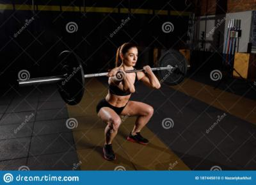

In [38]:
Image.open(test_img_path).to_thumb(256, 256)

This image is part of the training data but it is labelled incorrectly. It was found when searching for deadlift images. The model was able to correctly predict that it should be a squat image.